In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from xgboost import XGBRegressor


# 2. Load dataset (use your processed/train split)
df = pd.read_csv("/Users/riadanas/Desktop/housing regression MLE/data/processed/feature_engineered.csv")

pd.set_option('display.max_columns', None)  # Show all columns in the output
pd.set_option('display.max_rows', None)     # Show all rows in the output

In [3]:
# Drop median_sale_price (leakage).
df = df.drop(columns=["median_sale_price"])

In [4]:
print(df.shape)
df.head(2)

(795682, 40)


,year,quarter,month,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,median_dom,avg_sale_to_list,sold_above_list,off_market_in_two_weeks,bank,bus,hospital,mall,park,restaurant,school,station,supermarket,Total Population,Median Age,Per Capita Income,Total Families Below Poverty,Total Housing Units,Median Rent,Median Home Value,Total Labor Force,Unemployed Population,Total School Age Population,Total School Enrollment,Median Commute Time,price,lat,lng,zipcode_freq,city_encoded
0,2014,4,12,98700.0,114.468864,66.498930,5.0,0.0,6.0,18.0,209.0,0.928091,0.000000,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3187.0,41.4,22328.0,3187.0,1300.0,825.0,142800.0,1612.0,385.0,3101.0,3101.0,1182.0,144196.333365,38.7352,-90.3501,123,172651.841291
1,2016,3,9,222900.0,114.774973,116.016713,110.0,105.0,111.0,81.0,44.0,0.990445,0.245455,0.428571,2.0,1.0,0.0,0.0,4.0,13.0,20.0,0.0,5.0,19968.0,32.8,24060.0,19960.0,7502.0,1347.0,161200.0,10726.0,687.0,18678.0,18678.0,9332.0,208628.100288,28.4343,-81.3630,125,244403.845857


In [5]:
# Define target and features
target = "price"   # adjust if needed
X = df.drop(columns=[target])
y = df[target]

# Split into train/validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)

Train shape: (636545, 39)
Validation shape: (159137, 39)


In [6]:
# ================================================
# Train a simple XGBoost Regressor
# ================================================
xgb_model = XGBRegressor(
    n_estimators=500,       # number of trees
    learning_rate=0.05,     # step size shrinkage
    max_depth=6,            # depth of each tree
    subsample=0.8,          # row sampling
    colsample_bytree=0.8,   # feature sampling
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [7]:
# ================================================
# Evaluate performance
# ================================================
y_pred = xgb_model.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print("XGBoost Performance:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")


XGBoost Performance:
MAE: 23146.40
RMSE: 39640.48
R²: 0.9868


✅ Notes for this setup

- No feature scaling → XGBoost doesn’t need it.

- No need to drop multicollinear features → trees handle it naturally.

- Default hyperparameters already give strong performance.

Later you can:

- Tune max_depth, learning_rate, n_estimators.

- Use early_stopping_rounds with a validation set.

- Check feature importance with xgb.feature_importances_.

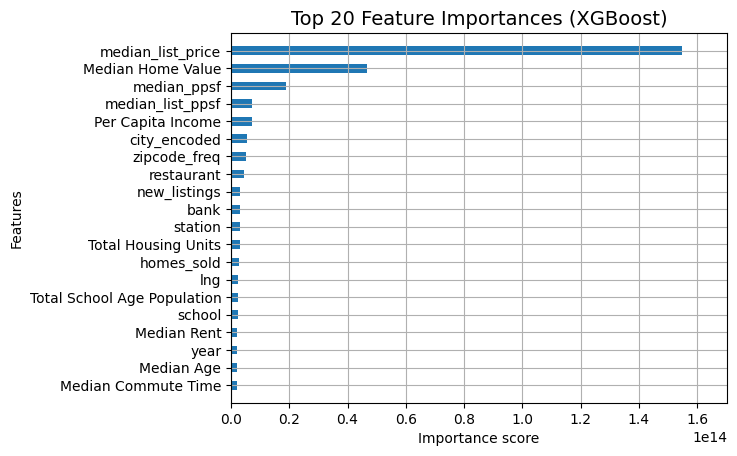

In [8]:
# Plot importances
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(
    xgb_model,
    importance_type="gain",
    max_num_features=20,
    height=0.5,
    show_values=False
)
plt.title("Top 20 Feature Importances (XGBoost)", fontsize=14)
plt.show()

Interpretation risk:

- The model is excellent at predicting this dataset’s prices because it’s using direct correlates.

- But if you deployed this model to predict future unseen prices, performance would likely drop (because you wouldn’t know the median sale price in advance).

🔹 Data Leakage suspicion

Leakage clue:

- If price is the actual transaction price, then median_sale_price is a summary statistic that already depends on those transactions.

- That means the model is being fed a “cheat sheet.”

👉 In practice:

- For a true predictive use case (predicting future house prices), you should exclude:

- median_sale_price

- median_list_price

And instead keep independent predictors:

- Location (lat, lng, zipcode)

- Supply/demand (inventory, new_listings)

- Socioeconomics (per_capita_income, median_age, employment)

🔹 Where do these features come from?

1. price (your target) → the actual transaction price of homes in a given city/month (dependent variable).

2. median_sale_price → the median of all recorded sale prices in that area and time period.

- This number is only known after homes are sold.

- It’s essentially a summary statistic of your target itself.

- Using it to predict price is circular → leakage. 

3. median_list_price → the median asking price of homes currently listed in that area and time period.

- This number is known before sales happen.

- It’s a legitimate predictor, because sellers’ expectations strongly influence final sale price.

In [10]:
# Save to processed folder
df.to_csv("/Users/riadanas/Desktop/housing regression MLE/data/processed/train_leakage_safe.csv", index=False)